# CH 6: Automate Event Planning

In this lesson, you will learn more about Tasks.

In [1]:
!pip install -qU crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

In [5]:
# import os
# from utils import get_openai_api_key

# openai_api_key = get_openai_api_key()
# os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'


bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

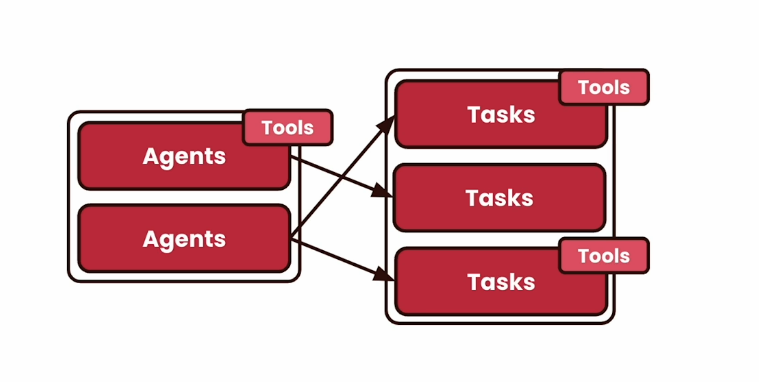

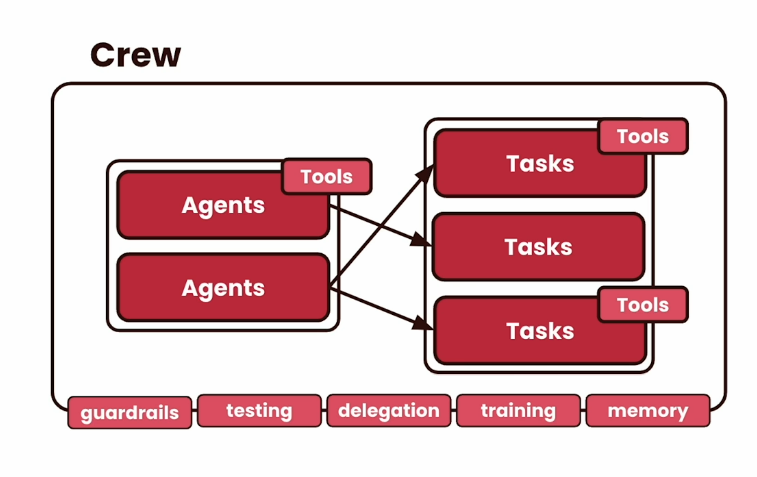

## crewAI Tools

In [6]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

## Creating Agents

In [7]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    llm=llm,
    max_iter=5,
    memory=True,
)

In [8]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipmen"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    ),
    llm=llm,
    max_iter=5,
    memory=True,
)

In [9]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    ),
    llm=llm,
    max_iter=5,
    memory=True,
)

## Creating Venue Pydantic Object

- Create a class `VenueDetails` using [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/).
- Agents will populate this object with information about different venues by creating different instances of it.

In [10]:
from pydantic import BaseModel
# Define a Pydantic model for venue details 
# (demonstrating Output as Pydantic)
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

## Creating Tasks
- By using `output_json`, you can specify the structure of the output you want.
- By using `output_file`, you can get your output in a file.
- By setting `human_input=True`, the task will ask for human feedback (whether you like the results or not) before finalising it.

In [11]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",  
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

- By setting `async_execution=True`, it means the task can run in parallel with the tasks which come after it.

In [12]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [13]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

## Creating the Crew

**Note**: Since you set `async_execution=True` for `logistics_task` and `marketing_task` tasks, now the order for them does not matter in the `tasks` list.

In [14]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator, 
            logistics_manager, 
            marketing_communications_agent],
    
    tasks=[venue_task, 
           logistics_task, 
           marketing_task],
    
    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [15]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

**Note 1**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

**Note 2**: 
- Since you set `human_input=True` for some tasks, the execution will ask for your input before it finishes running.
- When it asks for feedback, use your mouse pointer to first click in the text box before typing anything.

In [16]:
result = event_management_crew.kickoff(inputs=event_details)

 [DEBUG]: == Working Agent: Venue Coordinator
 [INFO]: == Starting Task: Find a venue in San Francisco that meets criteria for Tech Innovation Conference.


> Entering new CrewAgentExecutor chain...
Thought: To find a suitable venue for the Tech Innovation Conference in San Francisco, I will need to gather information about the event requirements and search for venues that meet those criteria.

Action: Ask question to co-worker
Action Input: {
    "coworker": "Logistics Manager",
    "question": "What are the key requirements for the Tech Innovation Conference venue in San Francisco?",
    "context": "I need to find a venue in San Francisco that can accommodate the Tech Innovation Conference. To search for appropriate venues, I need to know details like the expected number of attendees, dates of the event, required amenities or spaces (e.g. exhibition halls, breakout rooms), budget constraints, and any other important criteria."
}


> Entering new CrewAgentExecutor chain...
Thought: To

This is the agent final answer: After considering the key requirements provided by the Logistics Manager and researching potential venues in San Francisco, I recommend booking the Moscone Center for the Tech Innovation Conference.

The Moscone Center is a premier convention and exhibition complex located in the heart of San Francisco. It offers the following features that align with the event's needs:

1. Capacity: The Moscone Center has a total of over 700,000 square feet of exhibition and meeting space, including the Moscone North, South, and West buildings. The largest space, the Moscone North Convention Center, can accommodate up to 30,000 attendees, which should be sufficient for the Tech Innovation Conference.

2. Location: Situated in the vibrant South of Market (SoMa) neighborhood, the Moscone Center is easily accessible by public transportation, including BART and Muni. It is also within walking distance of numerous hotels, restaurants, and attractions, making it convenient fo



> Finished chain.
 Failed to convert text into JSON. Using raw output instead.
 [DEBUG]: == [Venue Coordinator] Task output: Agent stopped due to iteration limit or time limit.


 [DEBUG]: == Working Agent: Logistics Manager
 [INFO]: == Starting Task: Coordinate catering and equipment for an event with 500 participants on 2024-09-15.
 [DEBUG]: == [Logistics Manager] Task output: Agent stopped due to iteration limit or time limit.


 [DEBUG]: == Working Agent: Marketing and Communications Agent
 [INFO]: == Starting Task: Promote the Tech Innovation Conference aiming to engage at least500 potential attendees.
 [DEBUG]: == [Marketing and Communications Agent] Task output: Agent stopped due to iteration limit or time limit.




> Entering new CrewAgentExecutor chain...


> Entering new CrewAgentExecutor chain...
Thought: To effectively promote the Tech Innovation Conference and engage potential attendees, I need to gather information about the event details, target audience, and potentia

Exception in thread Thread-6 (_execute):
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/crewai/task.py", line 182, in _execute
    result = agent.execute_task(
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/crewai/agent.py", line 221, in execute_task
    result = self.agent_executor.invoke(
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/langchain/chains/base.py", line 163, in invoke
    raise e
  File "/home/ec2-user/anaconda3/env

- Display the generated `venue_details.json` file.

In [23]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

- Display the generated `marketing_report.md` file.

**Note**: After `kickoff` execution has successfully ran, wait an extra 45 seconds for the `marketing_report.md` file to be generated. If you try to run the code below before the file has been generated, your output would look like:

```
marketing_report.md
```

If you see this output, wait some more and than try again.

In [20]:
from IPython.display import Markdown
Markdown("marketing_report.md")

## Tech Innovation Conference Marketing Report

### Overview

The Tech Innovation Conference is a premier event that brings together entrepreneurs, investors, developers, engineers, product managers, and executives from the technology industry. While specific details about the date, location, and agenda are not available, this report outlines potential marketing strategies and tactics to effectively promote the conference and engage attendees based on insights from similar tech events.

### Target Audience

The primary target audience for the Tech Innovation Conference includes:

- Entrepreneurs and startup founders seeking funding, networking opportunities, and insights into emerging technologies.
- Investors looking to discover promising startups and innovative ideas to invest in.
- Developers and engineers interested in learning about cutting-edge technologies, best practices, and industry trends.
- Product managers and executives from established tech companies seeking to stay ahead of the curve and explore potential partnerships or acquisitions.

### Marketing Channels

To reach and engage the target audience, a multi-channel marketing approach is recommended, leveraging both online and offline channels:

**Online Channels**

- **Website and SEO**: Develop a dedicated website for the conference with detailed information about the event, speakers, agenda, and registration. Optimize the website for search engines using relevant keywords related to tech innovation, emerging technologies, and the conference's focus areas.
- **Social Media**: Establish a strong presence on platforms like LinkedIn, Twitter, and Facebook. Share updates, teasers, and behind-the-scenes content to build anticipation and engage the tech community. Leverage relevant hashtags and influencer collaborations to amplify reach.
- **Email Marketing**: Build an email list of potential attendees, industry professionals, and past conference participants. Send regular email campaigns highlighting keynote speakers, session highlights, and early bird registration discounts.
- **Online Advertising**: Utilize targeted online advertising platforms like Google Ads, LinkedIn Ads, and industry-specific websites or publications to reach a relevant audience based on their interests and demographics.

**Offline Channels**

- **Industry Events and Meetups**: Participate in local and regional tech events, meetups, and conferences as sponsors, exhibitors, or speakers. Distribute promotional materials and engage with potential attendees face-to-face.
- **Direct Mail**: Develop a targeted direct mail campaign for key decision-makers and influencers in the tech industry, highlighting the conference's unique value proposition and benefits.
- **Strategic Partnerships**: Collaborate with industry associations, tech hubs, accelerators, and influential organizations to cross-promote the conference and leverage their networks.

### Attendee Engagement

To maximize attendee engagement and create a memorable experience, consider implementing the following strategies:

- **Interactive Sessions**: Incorporate interactive elements such as live demos, hands-on workshops, and Q&A sessions to encourage active participation and knowledge sharing.
- **Networking Opportunities**: Facilitate networking by organizing dedicated networking sessions, meetups, or a conference app that allows attendees to connect and schedule meetings.
- **Gamification and Contests**: Introduce gamification elements, such as leaderboards, quizzes, or contests, to incentivize attendee participation and engagement throughout the conference.
- **Social Media Integration**: Encourage attendees to share their experiences on social media using a dedicated conference hashtag. Amplify user-generated content and engage with attendees in real-time.
- **Post-Event Follow-up**: Collect attendee feedback through surveys and follow up with personalized communications, sharing event highlights, recorded sessions, and information about future conferences or related events.

By implementing a comprehensive marketing strategy and focusing on attendee engagement, the Tech Innovation Conference can effectively reach its target audience, generate excitement, and create a memorable experience for all participants.